In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np


# 1. mnist tran, test dataset 가져오기

In [5]:


mnist_train=dset.MNIST("", train=True, transform=transforms.ToTensor(),
                      target_transform=None, download=True)
mnist_test=dset.MNIST("", train=False, transform=transforms.ToTensor(),
                     target_transform=None, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST/raw/train-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST/raw/train-labels-idx1-ubyte.gz to MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST/raw



# 2.대략적인 데이터 형태

mnist_train 길이: 60000
mnist_test 길이: 10000
image data 형태 torch.Size([1, 28, 28])
label:  5


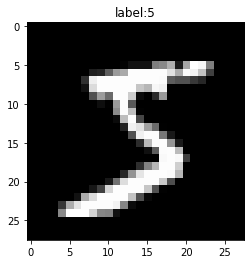

In [6]:
print ("mnist_train 길이:", len(mnist_train))
print ("mnist_test 길이:", len(mnist_test))

(image, label)=mnist_train.__getitem__(0)
print ("image data 형태", image.size())
print ("label: ", label)

img = image.numpy()
plt.title("label:%d" %label)
plt.imshow(img[0], cmap="gray") 
plt.show()

# 3. 데이터 로드함수


In [7]:
batch_size = 1024
learning_rate = 0.01
num_epoch=400


train_loader= torch.utils.data.DataLoader(mnist_train,
                                         batch_size=batch_size,
                                         shuffle=True, num_workers=2,
                                         drop_last=True)
test_loader= torch.utils.data.DataLoader(mnist_test,
                                         batch_size=batch_size,
                                         shuffle=False, num_workers=2,
                                         drop_last=True)

[0]
한 번에 로드되는 데이터 크기: 1024


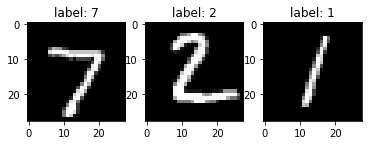

[1]
한 번에 로드되는 데이터 크기: 1024


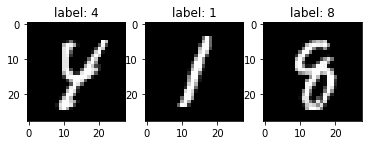

[2]
한 번에 로드되는 데이터 크기: 1024


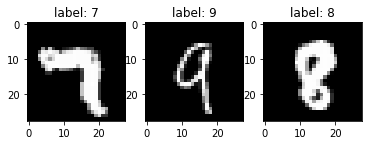

[3]
한 번에 로드되는 데이터 크기: 1024


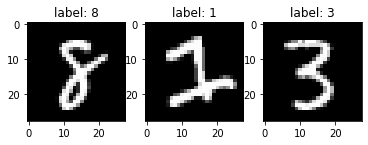

[4]
한 번에 로드되는 데이터 크기: 1024


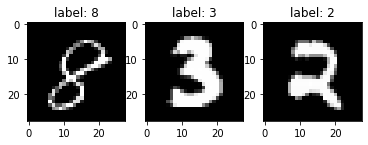

[5]
한 번에 로드되는 데이터 크기: 1024


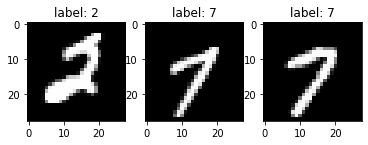

In [8]:
n=3
for i, [imgs, labels] in enumerate(test_loader):
    if i>5:
        break
    print ("[%d]" %i)
    print ("한 번에 로드되는 데이터 크기:", len(imgs))
    

    for j in range(3):
        img = imgs[j].numpy()
        img= img.reshape((img.shape[1], img.shape[2]))
        
        
        plt.subplot(1, n, j+1)
        plt.imshow(img, cmap='gray')
        plt.title("label: %d" %labels[j])
    plt.show()

# 4.모델선언

In [9]:
model = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.Sigmoid(),
    nn.Linear(256,128),
    nn.Linear(128,10),
)



In [10]:
model=model.cuda()

In [12]:
def ComputeAccr(dloader, imodel):
    correct =0
    total = 0
    
    for j, [imgs, labels] in enumerate(dloader):
        img= imgs
        
        label= Variable(labels).cuda()
        
        img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
        
        img = img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
        
        img= Variable(img, requires_grad=False).cuda()
        
        output = imodel(img)
        _, output_index = torch.max(output,1)
        
        total += label.size(0)
        correct += (output_index == label).sum().float()
    print("Accuracy of Test Data:{}".format(100*correct/total))

In [13]:
ComputeAccr(test_loader, model)

Accuracy of Test Data:9.309895515441895


# 5.loss, optimizer

In [14]:
loss_func= nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 학습

In [15]:
num_epoch = 400
for i in range(num_epoch):
    for j, [imgs, labels] in enumerate(train_loader):
        img= imgs
        label= Variable(labels).cuda()
        
        img = img.reshape((img.shape[0], img.shape[2], img.shape[3]))
        
        img = img.reshape((img.shape[0], img.shape[1]*img.shape[2]))
        img= Variable(img, requires_grad=True).cuda()
        
        optimizer.zero_grad()
        output = model(img)
        loss = loss_func(output, label)
        
        loss.backward()
        optimizer.step()
        
    if i%50==0:
        print("%d.." %i)
        ComputeAccr(test_loader, model)
        print (loss)

0..
Accuracy of Test Data:11.295573234558105
tensor(2.2925, device='cuda:0', grad_fn=<NllLossBackward0>)
50..
Accuracy of Test Data:82.29166412353516
tensor(0.6348, device='cuda:0', grad_fn=<NllLossBackward0>)
100..
Accuracy of Test Data:88.41146087646484
tensor(0.4205, device='cuda:0', grad_fn=<NllLossBackward0>)
150..
Accuracy of Test Data:89.81119537353516
tensor(0.3363, device='cuda:0', grad_fn=<NllLossBackward0>)
200..
Accuracy of Test Data:90.65755462646484
tensor(0.3739, device='cuda:0', grad_fn=<NllLossBackward0>)
250..
Accuracy of Test Data:91.14583587646484
tensor(0.2809, device='cuda:0', grad_fn=<NllLossBackward0>)
300..
Accuracy of Test Data:91.54730987548828
tensor(0.3130, device='cuda:0', grad_fn=<NllLossBackward0>)
350..
Accuracy of Test Data:91.80772399902344
tensor(0.2663, device='cuda:0', grad_fn=<NllLossBackward0>)


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# 7.테스트

In [16]:
ComputeAccr(test_loader, model)

Accuracy of Test Data:91.9921875


# 8.학습된 파라미터 저장

In [18]:
netname = "mlp_weight.pkl"
torch.save(model, netname, )